<a href="https://colab.research.google.com/github/jnksgit/Hoffmann-2022-rs/blob/main/thesis_sebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting forest composition and structure variables with remote sensing and deep learning**

This notebook shows the steps of the prediction of forest structure and tree species diversity with Sentinel-1 and -2 image metrics based on data from three characteristic Central European forest sites across Germany by using a forward feed deep neural network (DNN). 

**Procedure**



*   Collection of plot data from the Biodiversity Exploratories Information System

*   Calculation of Shannon Diversity Index based on plot tree species data

*   Applying s2cloudmask algorithm on Sentinel-2 data with GEE

*   Extraction of Sentinel-2 time series values based on plots with GEE

*   Calculation of Shannon Entropy based on S2-NIR band

*   Extraction of Sentinel-1 backscatter values based on plots with GEE

*   Preprocessing of input data (standardization, normalization)

*   Calibration and evaluation of DNN model

*   Test for spatial autocorrelation with Moran's I

*   Applying the model to raster data of exploratories extent





**Forest data acquisition**

In a preliminary step the required plot data was downloaded from Bexis.

Following variables have been gathered:
(not all variables were used in the final analysis)

* Climate data (mean average annual precipitation and temperature 2m above ground from 2008 to 2020)
* Forest Management Intensity Index [24646]
* Species mixture [17706]
* Forest type [17706]
* Soil type [1000]
* Elevation [11603]
* Number of tree species [22766]
* Standard deviation of Diameter Breast Height [22766]
* Reineke's Stand Density Index [22766]
* Average tree height [19986]
* Basal area of conifers [22766]
* Tree age [17486]


In [1]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials #Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Load and print the dataframe with the link provided in Google Drive
link = 'https://drive.google.com/file/d/1BwRjdNa5eM4UMCcQ85fky8HmLiRwNGLd/view?usp=sharing'
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('DNN_input.csv')  
  
df = pd.read_csv('DNN_input.csv')
print(df)

    Exploratory     EP  Ta_2_ann    P_ann    soil_type  slope  aspect  \
0           ALB  AEW01  8.092813  1030.00     Cambisol   2.40  264.37   
1           ALB  AEW02  6.687140   910.75     Leptosol   2.77  272.43   
2           ALB  AEW03  7.163209   959.33     Cambisol   7.25  355.40   
3           ALB  AEW04  7.488208   944.62     Cambisol  18.36   15.13   
4           ALB  AEW05  7.146965   997.81     Cambisol   5.55  172.35   
..          ...    ...       ...      ...          ...    ...     ...   
145         SCH  SEW46  8.966708   563.21  Albeluvisol   1.07  238.06   
146         SCH  SEW47  8.024260   563.21     Cambisol   2.32  124.46   
147         SCH  SEW48  8.828378   588.65     Cambisol   3.29  262.87   
148         SCH  SEW49  9.655843   642.50     Cambisol   3.56  325.21   
149         SCH  SEW50  9.306875   644.74     Cambisol   2.97  182.57   

     elevation                           type mixture   N   DBH_sd     SCI  \
0       747.84      Spruce_AC_immature_timber

**Calculation of Shannon Diversity Index on plot-based species data**

As a measure of tree species abundance and richness the Shannon diversity index is used. It is calculated with the ecological data analysis tool "EcoPy" based on a dataset containing the number of individuals per tree species for each plot (data bears on trees with a DBH of at least 7cm)

In [3]:
# Import the dataframe containing the species abundance information (columns: number per species, rows: plots)
link1 = 'https://drive.google.com/file/d/16TBv9EsAyDQA0KEDTPy3v_somjznoDw4/view?usp=sharing'
id1 = link1.split("/")[-2]
downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('Forest_abundance.csv')  

col_names = ["EP", "Abies_alba", "Acer_campestre", "Acer_platanoides","Acer_pseudoplatanus", "Acer_spec", "Aesculus_hippocastanum", "Alnus_spec", "Betula_pendula", "Betula_spec", "Carpinus_betulus", "Carya_ovata", "Fagus_sylvatica", "Fraxinus_excelsior", "Larix_decidua", "Larix_spec", "Malus_sylvestris", "Picea_abies", "Pinus_sylvestris", "Populus_nigra","Populus_tremula", "Prunus_avium", "Prunus_serotina", "Pseudotsuga_menziesii", "Pyrus_pyraster", "Quercus_spec", "Robinia_pseudoacacia", "Salix_caprea", "Salix_spec", "Sorbus_aria", "Sorbus_aucuparia", "Sorbus_torminalis", "Tilia_cordata", "Tilia_platyphyllos", "Tilia_spec", "Ulmus_glabra", "Ulmus_spec", "SUM"]
df1 = pd.read_csv('Forest_abundance.csv', names = col_names)
print(df1)

        EP  Abies_alba  Acer_campestre  Acer_platanoides  Acer_pseudoplatanus  \
0    AEW01           9               1                 0                    1   
1    AEW02           0               0                 0                    0   
2    AEW03           0               0                 0                    0   
3    AEW04           0               0                 0                    1   
4    AEW05           0               0                 0                    1   
..     ...         ...             ...               ...                  ...   
145  SEW46           0               0                 0                    0   
146  SEW47           0               0                 0                    0   
147  SEW48           0               0                 0                    0   
148  SEW49           0               0                 0                    0   
149  SEW50           0               0                 0                    0   

     Acer_spec  Aesculus_hi

In [5]:
# Install and import the neccessary libraries and tools for calculation of Shannon Index
import numpy as np
from scipy.special import comb
import scipy.misc
scipy.misc.comb = comb
#!pip install ecopy
import ecopy as ep 

In [6]:
# Calculate Shannon diversity index, before drop columns "EP" and "SUM"
df2 = df1.drop(['EP', 'SUM'], axis = 1)
#df2

shannon_index = ep.diversity (df2, "shannon", num_equiv = False)
#print (shannon_index)

# Add Shannon Index to dataframe
df3 = pd.DataFrame(df)
df3['H'] = pd.Series(shannon_index, index = df3.index)
#df3

In [7]:
print(df3.loc[df['EP'] == 'SEW47'])

    Exploratory     EP  Ta_2_ann   P_ann soil_type  slope  aspect  elevation  \
146         SCH  SEW47   8.02426  563.21  Cambisol   2.32  124.46      76.02   

                              type mixture  N   DBH_sd     SCI     CEA  \
146  Beech_unmanaged_mature_timber    pure  4  20.3306  3.7593  1.1565   

          BA      SDI      h  con_BA  age_MTS         H  
146  34.8174  502.434  33.11  0.3431      147  0.256141  


**Satellite data preprocessing**

Based on the Sentinel-2 cloud probability dataset clouds are masked from Sentinel-2 SR collection before extracting time series data. For this, Geemap, a Python API for Google Earth Engine was utilized. Monthly aggregated band values of Sentinel-2 are later used as model input features for the prediction of the Shannon diversity index.

In [9]:
# Install and import geemap, load a map to see how you can interact with Google Earth Engine
#!pip install geemap

import ee
import geemap

Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [10]:
# In this part the Sentinel-2 data is downloaded, visualized and zonal statistics of each band based on the forest plots are extracted
# Map for visualizing Sentinel-2 data
Bexis_map = geemap.Map()

# Import of forest plot data as regional filters
EP_plots = ee.FeatureCollection('users/janikhoffmann1/Forest_EP_all')
explo = 'ALB'
region = EP_plots.filter(ee.Filter.eq('Explrtr', explo)).geometry().bounds();
Bexis_map.addLayer(region)
Bexis_map.centerObject(region)

# Temporal parameters

year = '2017'
START_DATE = ee.Date(year+'-03-01')
END_DATE = ee.Date(year+'-10-01')

# Cloud mask parameters

CLOUD_FILTER = 60;
CLD_PRB_THRESH = 50;
NIR_DRK_THRESH = 0.15;
CLD_PRJ_DIST = 2;
BUFFER = 100;

# Apply masks for 20 and 60m bands

def maskEdges(s2_img):
  return s2_img.updateMask(
      s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()));

# Here a couple of functions are produced to link both datasets and to add cloud and cloud shadow bands to Sentinel-2 SR product

# Sentinel-2 SR and Sentinel-2 cloud probability are two different image collections that need to be filtered similarly by region and date

def get_s2_sr_cld_col(aoi, start_date, end_date):
   s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
        .map(maskEdges))
   s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))
   return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

# Apply the function to build a collection according to the parameters defined above

s2_sr_cld_col = get_s2_sr_cld_col(region, START_DATE, END_DATE)

# Definition of cloud mask cloud components

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

# Definition of cloud mask shadow components

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

# Definition of a function assembling all the above parameters to build the cloud mask

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)


# Apply cloud and cloud shadow mask and display image collection

def apply_cld_shdw_mask(img) :
    not_cld_shdw = img.select('cloudmask').Not()
    return img.select('B.*').updateMask(not_cld_shdw)

#print(s2_sr_cld_col)

s2CloudMasked = (s2_sr_cld_col.map(add_cld_shdw_mask)
                              .map(apply_cld_shdw_mask))

#Bexis_map.addLayer(s2CloudMasked.filterBounds(region),
 #                 {'bands': ['B4', 'B3', 'B2'], 
  #                'min' : 0,
   #               'max' : 3000})

S2_testimage = s2CloudMasked.median()

Bexis_map.addLayer(S2_testimage.clip(region),
                   {'bands': ['B4', 'B3', 'B2'], 
                   'min' : 0,
                   'max' : 3000})


# Download each band as image 

#geemap.ee_export_image_to_drive(S2_testimage, description='S2SCH2017.tif', folder='/Users/janikhoffmann/Downloads', region=region, scale=10)

# Extract median pixel band values for EPs 

S2_subset = S2_testimage.select(["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"])

import os

out_dir = os.path.expanduser('/Users/janikhoffmann/Downloads/DNN_data')

if not os.path.exists(out_dir):
  os.makedirs(out_dir)

out_S2 = os.path.join(out_dir, 'S2SCH2017.csv')

# Export zonal statistics 
#geemap.zonal_statistics(S2_subset, EP_plots.filter(ee.Filter.eq('Explrtr', explo)), out_S2, statistics_type='MEAN', scale=10)

Bexis_map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
# Visualize Sentinel-2 image in Geemap
Bexis_map.addLayer(S2_subset.clip(region), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000})
Bexis_map

Map(bottom=90927.0, center=[48.45561965661709, 9.503173828125], controls=(WidgetControl(options=['position', '…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# In a next step the generated datasets from each exploratory have to be stacked and linked to the model dataset

link_alb_s2 = "https://drive.google.com/file/d/1dhcb5PzhJ9AxNqyGC5Yu1AFI4Ihc3wcg/view?usp=sharing"
id_alb_s2 = link_alb_s2.split("/")[-2]
downloaded_alb_s2 = drive.CreateFile({'id':id_alb_s2}) 
downloaded_alb_s2.GetContentFile('S2ALB2017.csv')  
  
df_alb_s2 = pd.read_csv('S2ALB2017.csv', delimiter = ';')
#print(df_alb_s2)

link_hai_s2 = "https://drive.google.com/file/d/1Wc9YsW3bwdgykVbDQAUK-z4LFaV2awZG/view?usp=sharing"
id_hai_s2 = link_hai_s2.split("/")[-2]
downloaded_hai_s2 = drive.CreateFile({'id':id_hai_s2}) 
downloaded_hai_s2.GetContentFile('S2HAI2017.csv')  
  
df_hai_s2 = pd.read_csv('S2HAI2017.csv', delimiter = ';')
#print(df_hai_s2)

link_sch_s2 = "https://drive.google.com/file/d/1YoOMFKoEf-sMg5-SxQb5ykWUATZh0PG4/view?usp=sharing"
id_sch_s2 = link_sch_s2.split("/")[-2]
downloaded_sch_s2 = drive.CreateFile({'id':id_sch_s2}) 
downloaded_sch_s2.GetContentFile('S2SCH2017.csv')  
  
df_sch_s2 = pd.read_csv('S2SCH2017.csv', delimiter = ';')
#print(df_sch_s2)


S2_stats_concat = pd.concat([df_alb_s2, df_hai_s2, df_sch_s2])
#print(S2_stats_concat)

model_parameters_S2 = pd.merge(df3, S2_stats_concat, on='EP')
model_parameters_S2_ = model_parameters_S2.drop(['Explrtr'], axis=1)
model_parameters_S2_.sort_values('EP')
model_parameters_S2_

,Exploratory,EP,Ta_2_ann,P_ann,soil_type,slope,aspect,elevation,type,mixture,...,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,ALB,AEW01,8.092813,1030.00,Cambisol,2.40,264.37,747.84,Spruce_AC_immature_timber,pure,...,83.584712,238.125962,128.272836,460.850213,1607.268727,2038.497893,2048.102606,2232.971442,741.172649,338.092879
1,ALB,AEW02,6.687140,910.75,Leptosol,2.77,272.43,737.34,Spruce_AC_immature_timber,pure,...,82.420535,217.751855,122.485263,402.206421,1354.564194,1726.862121,1788.603249,1877.808993,649.043156,280.698766
2,ALB,AEW03,7.163209,959.33,Cambisol,7.25,355.40,693.43,Spruce_AC_immature_timber,pure,...,83.524245,216.580352,118.833966,400.018811,1432.066468,1832.394987,1871.552363,2021.386888,674.535802,311.589075
3,ALB,AEW04,7.488208,944.62,Cambisol,18.36,15.13,764.66,Beech_AC_pole_wood,pure,...,159.993772,437.060622,228.435011,1010.826145,4013.634939,5126.549136,5142.594382,5572.015078,2231.053593,1024.690095
4,ALB,AEW05,7.146965,997.81,Cambisol,5.55,172.35,788.19,Beech_AC_mature_timber,pure,...,124.610884,328.857353,154.695208,657.701126,2496.127455,3218.815575,3278.875003,3538.995591,1743.253310,761.527458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SCH,SEW46,8.966708,563.21,Albeluvisol,1.07,238.06,80.04,Beech_unmanaged_mature_timber,pure,...,267.428359,544.608999,240.850073,902.409041,3586.623942,4225.106635,4213.937864,4454.170000,1796.702677,831.677567
146,SCH,SEW47,8.024260,563.21,Cambisol,2.32,124.46,76.02,Beech_unmanaged_mature_timber,pure,...,250.186754,569.866449,233.150623,911.066894,3253.161878,3808.878130,3831.040529,4053.566480,1770.336786,825.860467
147,SCH,SEW48,8.828378,588.65,Cambisol,3.29,262.87,74.56,Beech_unmanaged_mature_timber,mixed,...,232.679140,562.181011,217.342163,1049.833389,3032.727548,3565.774773,3593.150246,3790.075490,1677.894089,759.369434
148,SCH,SEW49,9.655843,642.50,Cambisol,3.56,325.21,65.48,Beech_AC_mature_timber,pure,...,208.503518,548.629143,214.211902,1111.690759,3104.645512,3708.727454,3778.655248,3929.059910,2020.835288,861.142634


After collecting the Sentinel-2 data, the Sentinel-1 data is extracted via Geemap.

In [13]:
# Create a Geemap for Sentinel-1
S1_map = geemap.Map()

# Set the image collection parameters(instrumentMode, polarisation, orbit properties, date, region) for a VH-based and VV-based collection

collection_VH = ee.ImageCollection("COPERNICUS/S1_GRD").filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).filterBounds(region).filterDate('2017-12-01', '2018-02-28').select(['VH'])

S1_VH = collection_VH.median()
S1_VH_expl = S1_VH.clip(region)

#S1_map.addLayer(S1_VH_expl, {'min': -21.953456769330714, 'max': -9.590647689503438}, "S1_VH_winter_expl")

collection_VV = ee.ImageCollection("COPERNICUS/S1_GRD").filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).filterBounds(region).filterDate('2017-12-01', '2018-02-28').select(['VV'])

S1_VV = collection_VV.median()
S1_VV_expl = S1_VV.clip(region)

#S1_map.addLayer(S1_VV_expl, {'min': -15.01210238503886, 'max': 0.14459616239682163}, "S1_VV_winter_expl")

#S1_map

out_dir_S1 = os.path.expanduser('/Users/janikhoffmann/Downloads')

if not os.path.exists(out_dir):
  os.makedirs(out_dir)

# Extract zonal statistics of Sentinel-1 data for forest plots
out_S1 = os.path.join(out_dir_S1, 'S1ALB2017_vv_desc.csv')
#geemap.zonal_statistics(S1_VV_expl, EP_plots.filter(ee.Filter.eq('Explrtr', explo)), out_S1, statistics_type='MEAN', scale=10)


In [17]:
# All backscatter data has been manually merged into one csv.file and is now combined with the model parameter dataset

link_s1 = 'https://drive.google.com/file/d/1xRrj-cm1sMiO8jFvQRoxESntlBJo5k7b/view?usp=sharing'

id_s1 = link_s1.split("/")[-2]
downloaded_s1 = drive.CreateFile({'id':id_s1}) 
downloaded_s1.GetContentFile('S1_data.csv')  
  
df_s1 = pd.read_csv('S1_data.csv', delimiter = ",")
print(df_s1)

model_parameters = pd.merge(model_parameters_S2_, df_s1, on='EP')
model_parameters.sort_values('EP')


from google.colab import files
model_parameters.to_csv('model_variables.csv') 
files.download('model_variables.csv')


        EP  VH_desc_year  VH_asc_year  VH_desc_winter  VH_asc_winter  \
0    AEW01    -19.027885   -14.980701      -18.789639     -16.166469   
1    AEW02    -20.349671   -15.514675      -19.380264     -17.055691   
2    AEW03    -19.956914   -15.742899      -18.987615     -17.003597   
3    AEW04    -14.407945   -15.419833      -14.759831     -15.547808   
4    AEW05    -13.935827   -14.078745      -14.342940     -14.157700   
..     ...           ...          ...             ...            ...   
145  SEW46    -14.875462   -22.558408      -14.686206     -21.092346   
146  SEW47    -14.440651   -48.448528      -13.992936     -33.480726   
147  SEW48    -14.768445   -13.586674      -13.923641     -13.028105   
148  SEW49    -14.357941   -13.664540      -13.810916     -13.694483   
149  SEW50    -14.460783   -48.386612      -13.807066     -33.487883   

     VV_desc_year  VV_asc_year  VV_desc_winter  VV_asc_winter  
0      -13.260826    -8.859643      -12.447233      -9.801797  
1      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# Print dataframe containing Sentinel-2 spectral band data and Sentinel-1 backscatter data
model_parameters

,Exploratory,EP,Ta_2_ann,P_ann,soil_type,slope,aspect,elevation,type,mixture,...,B11,B12,VH_desc_year,VH_asc_year,VH_desc_winter,VH_asc_winter,VV_desc_year,VV_asc_year,VV_desc_winter,VV_asc_winter
0,ALB,AEW01,8.092813,1030.00,Cambisol,2.40,264.37,747.84,Spruce_AC_immature_timber,pure,...,741.172649,338.092879,-19.027885,-14.980701,-18.789639,-16.166469,-13.260826,-8.859643,-12.447233,-9.801797
1,ALB,AEW02,6.687140,910.75,Leptosol,2.77,272.43,737.34,Spruce_AC_immature_timber,pure,...,649.043156,280.698766,-20.349671,-15.514675,-19.380264,-17.055691,-13.519457,-9.354222,-12.665298,-10.500248
2,ALB,AEW03,7.163209,959.33,Cambisol,7.25,355.40,693.43,Spruce_AC_immature_timber,pure,...,674.535802,311.589075,-19.956914,-15.742899,-18.987615,-17.003597,-13.293899,-9.666680,-12.367380,-10.749787
3,ALB,AEW04,7.488208,944.62,Cambisol,18.36,15.13,764.66,Beech_AC_pole_wood,pure,...,2231.053593,1024.690095,-14.407945,-15.419833,-14.759831,-15.547808,-9.033992,-10.130688,-9.971234,-10.287178
4,ALB,AEW05,7.146965,997.81,Cambisol,5.55,172.35,788.19,Beech_AC_mature_timber,pure,...,1743.253310,761.527458,-13.935827,-14.078745,-14.342940,-14.157700,-8.568683,-8.846402,-9.103271,-8.924169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SCH,SEW46,8.966708,563.21,Albeluvisol,1.07,238.06,80.04,Beech_unmanaged_mature_timber,pure,...,1796.702677,831.677567,-14.875462,-22.558408,-14.686206,-21.092346,-9.394022,-16.981311,-9.439009,-14.865945
146,SCH,SEW47,8.024260,563.21,Cambisol,2.32,124.46,76.02,Beech_unmanaged_mature_timber,pure,...,1770.336786,825.860467,-14.440651,-48.448528,-13.992936,-33.480726,-8.881892,-48.448520,-8.624413,-30.671420
147,SCH,SEW48,8.828378,588.65,Cambisol,3.29,262.87,74.56,Beech_unmanaged_mature_timber,mixed,...,1677.894089,759.369434,-14.768445,-13.586674,-13.923641,-13.028105,-8.979067,-8.024094,-8.748441,-8.074289
148,SCH,SEW49,9.655843,642.50,Cambisol,3.56,325.21,65.48,Beech_AC_mature_timber,pure,...,2020.835288,861.142634,-14.357941,-13.664540,-13.810916,-13.694483,-8.823086,-8.309978,-8.779686,-8.147865


In [24]:
# In addition to the 10 Sentinel-2 spectral bands and the 8 Sentinel-1 backscatter predictors, other predictors have been computed in the Google Earth Engine and ArcGIS from this data.
# All predictors have been concatenated into one dataframe

link = 'https://drive.google.com/file/d/1oNB7j3khOhQVz3udV9njFzXo2w2rdxEr/view?usp=sharing'
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('model_parameters.csv')  
  
model_parameters = pd.read_csv('model_parameters.csv')
model_parameters

,Exploratory,EP,Ta_2_ann,P_ann,soil_type,slope,aspect,elevation,type,mixture,...,EVI_diss,EVI_entr,EVI_idm,EVI_var,S1_contrast,S1_diss,S1_entr,S1_idm,S1_var,Q
0,ALB,AEW01,8.092813,1030.00,Cambisol,2.40,264.37,747.84,Spruce_AC_immature_timber,pure,...,1.854167,1.877838,0.415856,2.571115,9.871745,2.565566,2.108887,0.307314,4.573278,0.491660
1,ALB,AEW02,6.687140,910.75,Leptosol,2.77,272.43,737.34,Spruce_AC_immature_timber,pure,...,1.958333,1.884917,0.400043,3.039931,8.533294,2.416667,2.094447,0.319349,4.397352,0.865405
2,ALB,AEW03,7.163209,959.33,Cambisol,7.25,355.40,693.43,Spruce_AC_immature_timber,pure,...,1.562500,1.909693,0.435252,1.890191,8.437500,2.458333,2.123328,0.301816,4.409722,0.435454
3,ALB,AEW04,7.488208,944.62,Cambisol,18.36,15.13,764.66,Beech_AC_pole_wood,pure,...,1.756526,1.950041,0.428503,2.628762,11.687500,2.875000,2.137768,0.258685,5.572229,0.693820
4,ALB,AEW05,7.146965,997.81,Cambisol,5.55,172.35,788.19,Beech_AC_mature_timber,pure,...,3.562500,2.051125,0.264310,9.681531,8.937500,2.479167,2.123328,0.295542,4.287760,0.602778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,SCH,SEW46,8.966708,563.21,Albeluvisol,1.07,238.06,80.04,Beech_unmanaged_mature_timber,pure,...,2.729167,2.022244,0.306227,5.621160,6.290060,2.062500,2.080006,0.350328,2.965613,0.475294
146,SCH,SEW47,8.024260,563.21,Cambisol,2.32,124.46,76.02,Beech_unmanaged_mature_timber,pure,...,3.908333,2.036684,0.261631,12.455681,7.594711,2.266654,2.123328,0.325958,3.839410,0.622625
147,SCH,SEW48,8.828378,588.65,Cambisol,3.29,262.87,74.56,Beech_unmanaged_mature_timber,mixed,...,3.680556,2.051125,0.256116,10.318287,8.101562,2.318670,2.065566,0.309942,3.623047,0.568926
148,SCH,SEW49,9.655843,642.50,Cambisol,3.56,325.21,65.48,Beech_AC_mature_timber,pure,...,3.506944,2.051125,0.278665,9.538194,6.387873,2.062500,2.080006,0.345818,2.913628,0.619362


**Calibration and evaluation of DNN model**

The following script builds a feed forward Deep Neural Network (DNN) that is calibrated with data from the three exploratories. As predictors Sentinel-2 composites from March-October and seasonal Sentinel-1 VV/VH backscatter composites are used. Response variables are tree species diversity and the std of the DBH of trees within plots. 

In [25]:
# Import libraries and data needed

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import statistics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.utils import shuffle
from sklearn import metrics

from google.colab import files
import io

In [26]:
# Explore and prepare the data

list (model_parameters.columns)

['Exploratory',
 'EP',
 'Ta_2_ann',
 'P_ann',
 'soil_type',
 'slope',
 'aspect',
 'elevation',
 'type',
 'mixture',
 'N',
 'DBH_sd',
 'h_sd',
 'SCI',
 'CEA',
 'BA',
 'SDI',
 'h',
 'con_BA',
 'age_MTS',
 'H',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'VH_desc_year',
 'VH_asc_year',
 'VH_desc_winter',
 'VH_asc_winter',
 'VV_desc_year',
 'VV_asc_year',
 'VV_desc_winter',
 'VV_asc_winter',
 'S1_ndi_mean',
 'S1_ndi_std',
 'EVI_mean',
 'EVI_std',
 'EVI_contrast',
 'EVI_diss',
 'EVI_entr',
 'EVI_idm',
 'EVI_var',
 'S1_contrast',
 'S1_diss',
 'S1_entr',
 'S1_idm',
 'S1_var',
 'Q']

In [27]:
model_parameters.head(5)

,Exploratory,EP,Ta_2_ann,P_ann,soil_type,slope,aspect,elevation,type,mixture,...,EVI_diss,EVI_entr,EVI_idm,EVI_var,S1_contrast,S1_diss,S1_entr,S1_idm,S1_var,Q
0,ALB,AEW01,8.092813,1030.00,Cambisol,2.40,264.37,747.84,Spruce_AC_immature_timber,pure,...,1.854167,1.877838,0.415856,2.571115,9.871745,2.565566,2.108887,0.307314,4.573278,0.491660
1,ALB,AEW02,6.687140,910.75,Leptosol,2.77,272.43,737.34,Spruce_AC_immature_timber,pure,...,1.958333,1.884917,0.400043,3.039931,8.533294,2.416667,2.094447,0.319349,4.397352,0.865405
2,ALB,AEW03,7.163209,959.33,Cambisol,7.25,355.40,693.43,Spruce_AC_immature_timber,pure,...,1.562500,1.909693,0.435252,1.890191,8.437500,2.458333,2.123328,0.301816,4.409722,0.435454
3,ALB,AEW04,7.488208,944.62,Cambisol,18.36,15.13,764.66,Beech_AC_pole_wood,pure,...,1.756526,1.950041,0.428503,2.628762,11.687500,2.875000,2.137768,0.258685,5.572229,0.693820
4,ALB,AEW05,7.146965,997.81,Cambisol,5.55,172.35,788.19,Beech_AC_mature_timber,pure,...,3.562500,2.051125,0.264310,9.681531,8.937500,2.479167,2.123328,0.295542,4.287760,0.602778


In [28]:
# Structure the dataset containing predictors and study variable to choice
Mydataset_vars = model_parameters.drop(['Exploratory',
 'EP',
 'Ta_2_ann',
 'P_ann',
 'soil_type',
 'slope',
 'aspect',
 'elevation',
 'type',
 'mixture',
 'N',
 #'DBH_sd',
 'h_sd',
 'SCI',
 'CEA',
 'BA',
 'SDI',
 'h',
 'con_BA',
 'age_MTS',
 'H',
 #'B2',  
 #'B3', 
 #'B4',
 #'B5',
 #'B6',
 #'B7',
 #'B8',
 #'B8A',
 #'B11',
 #'B12',
 #'VH_desc_year',
 #'VH_asc_year',
 #'VH_desc_winter',
 #'VH_asc_winter',
 #'VV_desc_year',
 #'VV_asc_year',
 #'VV_desc_winter',
 #'VV_asc_winter',
 #'S1_ndi_mean',
 #'S1_ndi_std',
 #'EVI_mean',
 #'EVI_std',
 #'EVI_contrast',
 #'EVI_diss',
 #'EVI_entr',
 #'EVI_idm',
 #'EVI_var',
 #'S1_contrast',
 #'S1_diss',
 #'S1_entr',
 #'S1_idm',
 #'S1_var',
 #'Q'
   ], axis=1)

In [29]:
Mydataset = Mydataset_vars.dropna()

In [30]:
# Set ghe study variable
studyvar = "DBH_sd"
Mydataset = pd.get_dummies(Mydataset, prefix='', prefix_sep='')
# Print the final model dataset
Mydataset.head(5)

,DBH_sd,B2,B3,B4,B5,B6,B7,B8,B8A,B11,...,EVI_diss,EVI_entr,EVI_idm,EVI_var,S1_contrast,S1_diss,S1_entr,S1_idm,S1_var,Q
0,7.7012,83.584712,238.125962,128.272836,460.850213,1607.268727,2038.497893,2048.102606,2232.971442,741.172649,...,1.854167,1.877838,0.415856,2.571115,9.871745,2.565566,2.108887,0.307314,4.573278,0.491660
1,11.3820,82.420535,217.751855,122.485263,402.206421,1354.564194,1726.862121,1788.603249,1877.808993,649.043156,...,1.958333,1.884917,0.400043,3.039931,8.533294,2.416667,2.094447,0.319349,4.397352,0.865405
2,9.4923,83.524245,216.580352,118.833966,400.018811,1432.066468,1832.394987,1871.552363,2021.386888,674.535802,...,1.562500,1.909693,0.435252,1.890191,8.437500,2.458333,2.123328,0.301816,4.409722,0.435454
3,4.5764,159.993772,437.060622,228.435011,1010.826145,4013.634939,5126.549136,5142.594382,5572.015078,2231.053593,...,1.756526,1.950041,0.428503,2.628762,11.687500,2.875000,2.137768,0.258685,5.572229,0.693820
4,13.0179,124.610884,328.857353,154.695208,657.701126,2496.127455,3218.815575,3278.875003,3538.995591,1743.253310,...,3.562500,2.051125,0.264310,9.681531,8.937500,2.479167,2.123328,0.295542,4.287760,0.602778


In [31]:
# Compute statistics of training data
train_stats = Mydataset.describe()
train_stats.pop(studyvar) #remove the study variable
train_stats = train_stats.transpose()
print(train_stats)

                count         mean         std          min          25%  \
B2              150.0   175.430715   48.766979    65.221251   148.766173   
B3              150.0   401.389745   84.719697   215.514177   359.688007   
B4              150.0   217.916726   57.349029    77.397815   179.722016   
B5              150.0   791.087054  173.987714   400.018811   701.772834   
B6              150.0  2631.460292  639.020755  1314.591730  2278.013382   
B7              150.0  3312.036215  845.438814  1638.720610  2746.634845   
B8              150.0  3384.475455  845.154031  1701.094574  2807.156009   
B8A             150.0  3602.645076  899.475111  1786.620917  3002.721830   
B11             150.0  1644.207284  398.160118   620.630120  1537.737522   
B12             150.0   759.402285  179.429732   280.698766   730.194658   
VH_desc_year    150.0   -14.931866    1.137325   -20.349671   -15.198700   
VH_asc_year     150.0   -14.936161    4.124225   -48.448528   -14.882037   
VH_desc_wint

Build the model

Here we build the model and control its hyper paramters. The model is composed of 4 layers. One layer that normalizes the data, two layers with 64 nodes/neurons each and the regularized activation function (relu), and an output layer. As optimizer we chose the RMSprop and the metric to evaluate the loss function is the Root mean square error. The loss function is given by the mean absolute error.

In [32]:
def build_model(normalizer):
  model = keras.Sequential([
    normalizer,
    layers.Dense(64, 
                 activation='relu', 
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 input_shape=[len(train_features.keys())]),
       
    layers.Dense(64, activation='relu',
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 ),
    
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
                #metrics=['mae','mse'])
  return model

In [33]:
# Define a function to plot the loss functions

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylim([0, max(Mydataset[studyvar])]) # adjust x and y lims to dataset 
  plt.xlim([0,EPOCHS])
  plt.xlabel('Epoch')
  plt.ylabel('Error [studyvar]')
  plt.legend()
  plt.grid(True)

The model is going to be run several times and accuracy values are stored in a list. This is important because the randomization of training and validation samples will bring slightly different results

In [34]:
RMSE_val_list = []
RMSE_test_list = []
RRMSE_test_list = []
rsq_list = []
predictions_list = []

#These lists will give the importance of each predictor
LOFO_list = []
LOFO_Ordered_list = []

Apply the model iteratively

We do a for loop to train and calibrate the model several times and store the accuracy metrics in the lists above. Within this loop we shuffle the data every time to make sure we collect different combinations of train and validation observations. We also perform the normalization of the training dataset.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


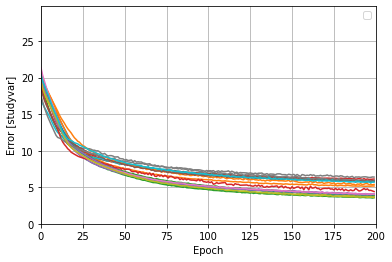

In [35]:
for iteration in range(10):
# Recommended to shuffle here, since despite the shuffle is True by default when we fit the model,
# the validation data has to be suffled before it is separated from the training data
    Mydataset = shuffle(Mydataset)
  
    # Random Distribution of train and test datasets
    train_dataset = Mydataset.sample(frac=0.8,random_state=0)
    test_dataset = Mydataset.drop(train_dataset.index)
        
    #Copy features so that the .pop doesn't fuck things up
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    
    #Create 'y' variables (labels) and 'x' (features)
    train_labels = train_features.pop(studyvar)
    test_labels = test_features.pop(studyvar)
    
    #######################################################################################
    # Normalzation
    #######################################################################################
    #Get statistics of the training dataset
    train_dataset.describe().transpose()[['mean', 'std']]
    
    #Create normalizer layer and adapt it to our data
    #with function preprocessing.Normalization()
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(train_features))
    
    ####################################################################################### 
    model = build_model(normalizer)
    #model.summary()
    EPOCHS = 200
    #######################################################################################
   
    #Train model
    #Keras fit function expects training features to be as array.
    history = model.fit(
        train_features, 
        train_labels, 
        epochs=EPOCHS, 
        validation_split = 0.2,
        verbose=0)
    
    #######################################################################################
    #Plot loss functions
    # Show last few epochs in history
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch  
   
    plot_loss(history)
    
    #To calibrate hyper parameters, we use  20% of the training data from the validation_split parameter (0.2)
    test_mean = test_labels.describe()[['mean']]
    RMSE = hist[(hist.epoch == (EPOCHS - 1))][['val_root_mean_squared_error']].squeeze()
    RMSE_val_list.append(RMSE)
    
    # Predictions
    # Make predictions on the test data using the model 
    test_predictions = model.predict(test_features).flatten()
    
    # Create a new column with the results of the predictions in the test_dataset
    test_dataset['preds'] = test_predictions
  
    # Merge the predicted results with the original dataset
    test_preds = pd.merge(model_parameters,test_dataset[['preds']], how = 'right',left_index = True, right_index = True)

    predictions_list.append(test_preds) 
    
    # Measure this run's RMSE using the test data
    RMSE_test = np.sqrt(metrics.mean_squared_error(test_predictions,test_labels))
    RMSE_test_list.append(RMSE_test)

    # Calculate the relative root mean squared error
    test_mean = np.mean(test_labels)
    RRMSE_test = (RMSE_test / test_mean)
    RRMSE_test_list.append(RRMSE_test) 
    
    # Calculate r2 between predicted and test data
    linreg = sp.stats.linregress(test_predictions ,test_labels)
    rsq = linreg.rvalue **2
    rsq_list.append(rsq)                                   

    # This function will return the variable importance using a leave-one.out approach and the loss function. 
    # It has to be defined withn the loop, otherwise it doesn't work    
    def LOFO(model, X, Y):
        OneOutScore = []
        n = X.shape[0]
        for i in range(0,X.shape[1]):
            newX = X.copy()
            newX.iloc[:,i] = 0 #np.random.normal(0,1,n)
            OneOutScore.append(model.evaluate(newX, Y, verbose=0))
        OneOutScore = pd.DataFrame(OneOutScore[:])
        ordered = np.argsort(-OneOutScore.iloc[:,0])
        return(OneOutScore, ordered)

    # apply on the model
    LOFO, LOFO_Ordered = LOFO(model, train_features, train_labels)
    LOFO_list.append(LOFO)
    LOFO_Ordered_list.append(LOFO_Ordered)

No handles with labels found to put in legend.


INFO:tensorflow:Assets written to: /Users/janikhoffmann/Desktop/SeBAS/DNN/Model_save/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

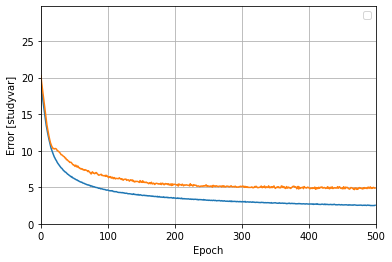

In [36]:
# This part is for running the model and save it for the application to raster data later
# Preprocess data
# in be_preprocessing.py, select the study variable and the predictors
# Create an object with the result of  the preprocessing module
# We have to define this to explore the dataset we work with
# and to relate results to other variables in the plots afterwards

studyvar = 'DBH_sd'
#MydatasetLUI = be_preprocessing.MydatasetLUI
#print(Mydataset.head())
#import modelDNN
# Random Distribution of train and test
train_dataset = Mydataset
    
#Copy features
train_features = train_dataset.copy()
#Create y variables (labels) and x (features)
train_labels = train_features.pop(studyvar)
#######################################################################################
# Normalzation
#######################################################################################
#Create normalizer layer and adapt it to our data
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
####################################################################################### 
model = build_model(normalizer)
EPOCHS = 500
#######################################################################################
   
#Train model
#Keras fit function expects training features to be as array.
history = model.fit(
    train_features, 
    train_labels, 
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=0)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_loss(history)
# Measure RMSE using the validation (0.2%) data
RMSE_val = hist[(hist.epoch == (EPOCHS - 1))][['val_root_mean_squared_error']].squeeze()
model.save('/Users/janikhoffmann/Desktop/SeBAS/DNN/Model_save')
files.download('/Users/janikhoffmann/Desktop/SeBAS/DNN/Model_save')

In [37]:
# Transform each of the elements of the list into a dataframe (necessary to concatenate them)
for df in predictions_list:
  pd.DataFrame(df)

In [38]:
# Concatenate all dataframes (basically, transform the list of dataframes to a big dataframe)
test_preds_all_ = pd.concat(predictions_list)

In [39]:
test_preds_all_.head(15)
test_preds_all_.to_csv(f"Preds_{studyvar}.csv")
files.download(f"Preds_{studyvar}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

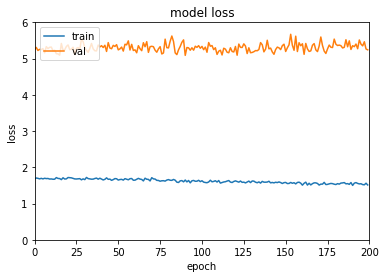

In [44]:
# Plot training and validation loss to analyse any over- or underfitting of the model
history = model.fit(train_features, train_labels,validation_split = 0.2, epochs=200, batch_size=4, verbose = 0)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xlim([0, 200])
plt.ylim([0, 6])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

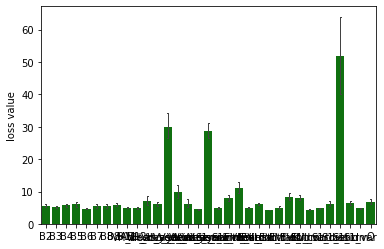

In [45]:
# list comprehension to get the first column loss
lofo1 = [item[0] for item in LOFO_list]

# transform list to df and rename variables
lofodf = pd.DataFrame(lofo1)
colnames = list(Mydataset.drop(studyvar, axis=1).columns)
lofodf.columns = colnames

sns.barplot(data=lofodf, 
            capsize = 0.1,
            errwidth=1,
            color='green')
plt.ylabel('loss value')

# create stats to export to csv
lofo_stats = lofodf.describe()
lofo_statst = lofo_stats.transpose()
lofo_stats.to_csv(f'Variable_importance_{studyvar}.csv')
files.download(f"Variable_importance_{studyvar}.csv")

In [46]:
# print average RMSE from the test dataset (you can compare it to the validation_split RMSE)
print(f"RMSE Median: {statistics.median(RMSE_test_list)}")
print(f"RMSE StdDev: {statistics.stdev(RMSE_test_list)}")

# print average RRMSE from the test dataset
print(f"RRMSE Median: {statistics.median(RRMSE_test_list)}") 
print(f"RRMSE StDev: {statistics.stdev(RRMSE_test_list)}")

# print average r squared in validation
print(f"r squared Median: {statistics.median(rsq_list)}") 
print(f"r squared StdDev: {statistics.stdev(rsq_list)}")

RMSE Median: 4.770740734832204
RMSE StdDev: 0.643992850649552
RRMSE Median: 0.3608671530481695
RRMSE StDev: 0.06283314121792259
r squared Median: 0.4602059133257143
r squared StdDev: 0.10262521730693909


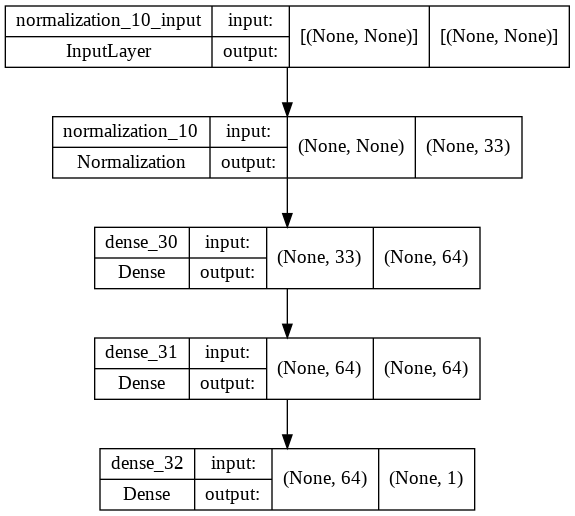

In [47]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [48]:
model.save('/Users/janikhoffmann/Desktop/SeBAS')

INFO:tensorflow:Assets written to: /Users/janikhoffmann/Desktop/SeBAS/assets


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

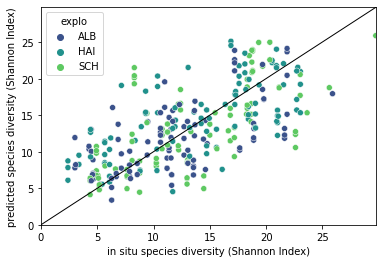

In [50]:
#Plot pred vs real values for the last run of the loop
#test_preds = test_preds.rename(columns = {'C:/Users/Janik/Documents/SatAnalysis':'ForMi'})

#plot by Explo
myplot = sns.scatterplot(studyvar, 'preds', data=test_preds_all_, hue = 'Exploratory', palette='viridis')
plt.xlabel('in situ species diversity (Shannon Index)')
plt.ylabel('predicted species diversity (Shannon Index)')
myplot.legend(title="explo")
plt.xlim(0, max(Mydataset[studyvar])) #max(Mydataset[studyvar])
plt.ylim(0, max(Mydataset[studyvar]))

#add a r=1 line
x = np.array([0,max(Mydataset[studyvar])])
plt.plot(x,x,lw=1, c="black")

plt.savefig("scatterplot_H.png")
files.download("scatterplot_H.png") 

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

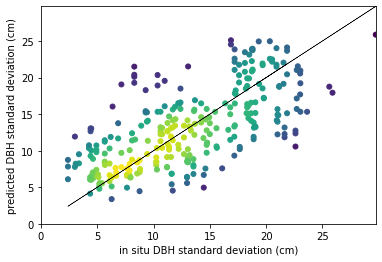

In [51]:
#Make a density plot
from scipy.stats import gaussian_kde
y = test_preds_all_['preds']
x = test_preds_all_[studyvar]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=25)
plt.ylabel(f'predicted DBH standard deviation (cm)')
plt.xlabel(f'in situ DBH standard deviation (cm)')
plt.xlim(0, max(Mydataset[studyvar]))
plt.ylim(0, max(Mydataset[studyvar]))
line = np.array([0,max(y)])
plt.plot(x,x,lw=0.5, c="black")


plt.savefig("densityplot_DBH.png")
files.download("densityplot_DBH.png") 

plt.show()


In [52]:
# identify outliers that are too far from a good prediction

outliers = test_preds[(test_preds['preds'] <= 50) & (test_preds[studyvar] >= 42)]
print(outliers[['EP']])

Empty DataFrame
Columns: [EP]
Index: []


Evaluation of model performance

To check which predictors are correlated.

In [54]:
corr = Mydataset.corr(method = "pearson")
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,DBH_sd,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,VH_desc_year,VH_asc_year,VH_desc_winter,VH_asc_winter,VV_desc_year,VV_asc_year,VV_desc_winter,VV_asc_winter,S1_ndi_mean,S1_ndi_std,EVI_mean,EVI_std,EVI_contrast,EVI_diss,EVI_entr,EVI_idm,EVI_var,S1_contrast,S1_diss,S1_entr,S1_idm,S1_var,Q
DBH_sd,1.00,0.18,0.30,0.06,0.24,0.18,0.13,0.14,0.13,0.25,0.24,0.26,-0.05,0.39,0.08,0.35,0.06,0.53,0.13,0.58,0.26,0.18,0.28,0.53,0.58,0.56,-0.60,0.52,0.30,0.31,0.33,-0.32,0.30,0.12
B2,0.18,1.00,0.76,0.79,0.55,0.34,0.29,0.30,0.28,0.44,0.51,0.42,-0.01,0.48,0.08,0.27,-0.09,0.37,-0.17,-0.07,-0.03,0.27,0.01,0.05,0.05,0.01,-0.05,0.04,-0.06,-0.05,-0.02,0.08,-0.06,0.08
B3,0.30,0.76,1.00,0.61,0.90,0.70,0.63,0.64,0.62,0.73,0.75,0.52,-0.05,0.67,0.10,0.47,0.00,0.61,0.01,0.13,0.06,0.62,0.18,0.25,0.30,0.35,-0.36,0.24,0.04,0.07,0.16,-0.10,0.02,0.24
B4,0.06,0.79,0.61,1.00,0.55,0.21,0.19,0.21,0.20,0.40,0.54,0.40,0.05,0.43,0.03,0.27,-0.03,0.33,-0.14,-0.08,0.02,0.11,-0.04,-0.01,-0.00,-0.02,0.00,-0.01,-0.06,-0.06,-0.00,0.08,-0.06,0.10
B5,0.24,0.55,0.90,0.55,1.00,0.80,0.76,0.77,0.76,0.84,0.86,0.53,0.04,0.71,0.15,0.52,0.10,0.64,0.11,0.13,0.08,0.73,0.21,0.25,0.32,0.43,-0.41,0.25,0.08,0.11,0.22,-0.16,0.05,0.23
B6,0.18,0.34,0.70,0.21,0.80,1.00,0.99,0.98,0.98,0.89,0.81,0.46,-0.01,0.65,0.14,0.49,0.07,0.58,0.12,0.11,0.07,0.98,0.16,0.19,0.26,0.43,-0.38,0.18,0.11,0.14,0.21,-0.20,0.08,0.23
B7,0.13,0.29,0.63,0.19,0.76,0.99,1.00,1.00,1.00,0.89,0.81,0.44,0.04,0.62,0.16,0.47,0.13,0.55,0.15,0.09,0.07,0.99,0.16,0.17,0.25,0.42,-0.37,0.16,0.10,0.13,0.20,-0.20,0.08,0.22
B8,0.14,0.30,0.64,0.21,0.77,0.98,1.00,1.00,1.00,0.90,0.82,0.45,0.05,0.63,0.16,0.48,0.13,0.56,0.15,0.09,0.07,0.99,0.15,0.17,0.25,0.42,-0.36,0.17,0.09,0.12,0.19,-0.19,0.07,0.22
B8A,0.13,0.28,0.62,0.20,0.76,0.98,1.00,1.00,1.00,0.90,0.82,0.44,0.05,0.62,0.17,0.47,0.14,0.55,0.16,0.08,0.08,0.99,0.16,0.18,0.25,0.43,-0.37,0.17,0.11,0.14,0.20,-0.20,0.08,0.22
B11,0.25,0.44,0.73,0.40,0.84,0.89,0.89,0.90,0.90,1.00,0.97,0.56,0.09,0.74,0.23,0.53,0.15,0.64,0.16,0.07,0.16,0.89,0.22,0.32,0.39,0.49,-0.46,0.31,0.17,0.19,0.25,-0.24,0.14,0.20


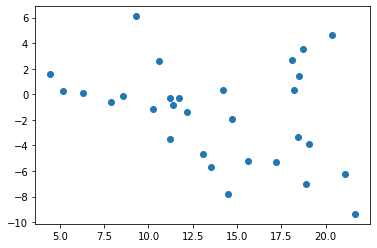

In [55]:
# Calculate and plot the residuals. There shouldn't be clusters visible

residuals = test_predictions - test_labels
plt.scatter(test_labels, residuals)

Text(0.5, 1.0, 'Residuals of predicted and test variable')

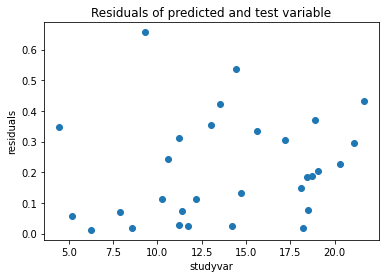

In [56]:
# See residuals normalized to see the error in percentage

ap_residuals = np.abs(residuals)/test_labels
plt.scatter(test_labels, ap_residuals)
plt.xlabel('studyvar')
plt.ylabel('residuals')
plt.title('Residuals of predicted and test variable')

(array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
        0.03333333, 0.03333333, 0.03333333, 0.06666667, 0.06666667,
        0.06666667, 0.1       , 0.1       , 0.1       , 0.1       ,
        0.1       , 0.1       , 0.13333333, 0.16666667, 0.16666667,
        0.16666667, 0.16666667, 0.2       , 0.2       , 0.2       ,
        0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
        0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
        0.2       , 0.2       , 0.2       , 0.23333333, 0.23333333,
        0.23333333, 0.23333333, 0.23333333, 0.23333333, 0.26666667,
        0.3       , 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
        0.33333333, 0.4       , 0.4       , 0.4       , 0.43333333,
        0.43333333, 0.43333333, 0.46666667, 0.46666667, 0.46666667,
        0.46666667, 0.46666667, 0.46666667, 0.53333333, 0.53333333,
        0.56666667, 0.56666667, 0.56666667, 0.6 

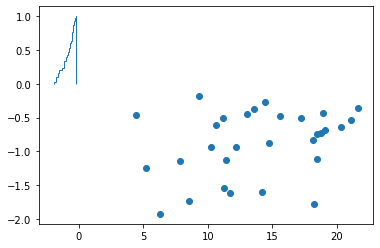

In [57]:
# Plot in log scale to compact data

lap_residuals = np.log10(ap_residuals)
plt.scatter(test_labels, lap_residuals)
plt.hist(lap_residuals, density = 1, bins = 100, histtype='step', cumulative = True)

Create a cummulative function of the distribution of errors. Zoomed to the center of t he axis it shows what percentage of our validation observations have an error lower than 100 or 10%(it is on a logaritmic scale)

(-1.5, 0.0, 0.0, 1.0)

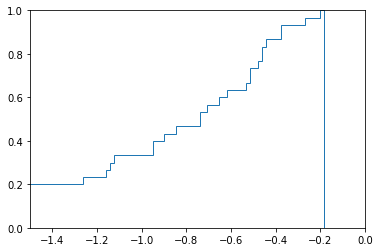

In [58]:
plt.hist(lap_residuals, density = 1, bins=100, histtype='step',cumulative=True);
plt.axis([-1.5,0,0,1])